# PBO learnt on several iterations and one weigth one the car on hill environment

## Define parameters

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import jax
import jax.numpy as jnp

# keys
seed = 0
key = jax.random.PRNGKey(seed)
shuffle_key, q_network_key, random_weights_key, pbo_network_key = jax.random.split(key, 4)

# Sample collection
n_states_x = 20
n_states_v = 20
n_actions = 2
n_samples = n_states_x * n_states_v * n_actions
gamma = 0.9

# # Weights collection
# n_weights = 500

# # Trainings
layers_dimension = (20, 20)
max_bellman_iterations = 10
batch_size_samples = n_samples

# ## Linear PBO
fitting_steps = 8
training_steps = 100
# batch_size_weights = n_weights
# learning_rate = {"first": 0.01, "last": 0.001, "duration": training_steps * fitting_steps * n_samples // batch_size_samples}

# ## Q-learning
fitting_steps_q = fitting_steps * training_steps
learning_rate_q = {"first": 0.01, "last": 0.0005, "duration": fitting_steps_q * n_samples // batch_size_samples}

# # Visualisation of errors and performances
# max_bellman_iterations_validation = max_bellman_iterations + 20
# horizon = 10

## Define environment

In [2]:
from pbo.environment.car_on_hill import CarOnHillEnv

max_pos = 1.0
max_velocity = 3.0

states_x = jnp.linspace(-max_pos, max_pos, n_states_x)
boxes_x_size = (2 * max_pos) / (n_states_x - 1)
states_x_boxes = (np.linspace(-max_pos, max_pos + boxes_x_size, n_states_x + 1) - boxes_x_size / 2)
states_v = jnp.linspace(-max_velocity, max_velocity, n_states_v)
boxes_v_size = (2 * max_velocity) / (n_states_v - 1)
states_v_boxes = (np.linspace(-max_velocity, max_velocity + boxes_v_size, n_states_v + 1) - boxes_v_size / 2)


env = CarOnHillEnv(max_pos, max_velocity, gamma)

## Collect samples

### Samples on the mesh

In [3]:
from pbo.sample_collection.replay_buffer import ReplayBuffer


replay_buffer = ReplayBuffer()

n_samples = n_states_x * n_states_v * n_actions

for state_x in states_x:
    for state_v in states_v:
        state = jnp.array([state_x, state_v])
        
        for action in jnp.arange(n_actions):
            env.reset(state)
            next_state, reward, _, _ = env.step(jnp.array([action]))

            replay_buffer.add(state, jnp.array([action]), reward, next_state)

replay_buffer.cast_to_jax_array()

### Visualize samples

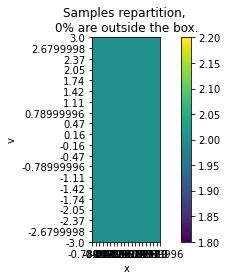

In [4]:
from pbo.sample_collection.count_samples import count_samples
from pbo.utils.two_dimesions_mesh import TwoDimesionsMesh


samples_count, n_outside_boxes = count_samples(replay_buffer.states[:, 0], replay_buffer.states[:, 1], states_x_boxes, states_v_boxes)
samples_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0)

samples_visu_mesh.set_values(samples_count, zeros_to_nan=True)
samples_visu_mesh.show(
    f"Samples repartition, \n{int(100 * n_outside_boxes / n_samples)}% are outside the box.", xlabel="x", ylabel="v"
)

## Optimal Q function

In [5]:
# optimal_v = env.optimal_v_mesh(states_x, states_v, max_steps=10)

# q_visu_mesh = TwoDimesionsMesh(states_x, states_v, sleeping_time=0)

# q_visu_mesh.set_values(optimal_v)
# q_visu_mesh.show("Optimal v function", xlabel="x", ylabel="v")

## Train Q with Fitted-Q

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

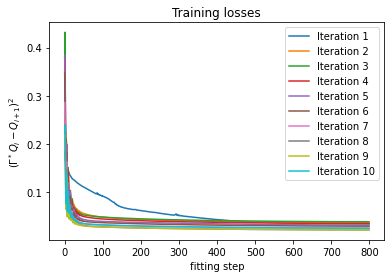

In [6]:
import matplotlib.pyplot as plt 
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.networks.learnable_q import FullyConnectedQ


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
q = FullyConnectedQ(
    state_dim=2,
    action_dim=1,
    continuous_actions=False,
    n_actions_on_max=n_actions,
    action_range_on_max=None,
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    learning_rate=learning_rate_q,
    layers_dimension=layers_dimension,
    zero_initializer=True,
)
validation_initial_weight = q.to_weights(q.params)

l2_losses = np.zeros((max_bellman_iterations, fitting_steps_q))

for bellman_iteration in tqdm(range(max_bellman_iterations)):
    params_target = q.params
    q.reset_optimizer()

    for step in tqdm(range(fitting_steps_q), leave=False):
        cumulative_l2_loss = 0
        
        data_loader_samples.shuffle()
        for batch_samples in data_loader_samples:
            q.params, q.optimizer_state, l2_loss = q.learn_on_batch(q.params, params_target, q.optimizer_state, batch_samples)
            cumulative_l2_loss += l2_loss

        l2_losses[bellman_iteration, step] = cumulative_l2_loss



for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

In [7]:
q.params

{'FullyConnectedNet/linear_1': {'b': DeviceArray([ 1.3971016 ,  1.1539813 ,  1.5840217 , -1.0679629 ,
               -1.465124  ,  0.07541741,  0.77470636,  2.2564056 ,
               -0.8290226 , -0.04282959, -0.29242182,  1.162372  ,
                0.5772206 , -1.3916606 , -1.2500947 , -0.2285249 ,
                0.48767728, -0.6001903 ,  1.1308362 , -1.1601233 ],            dtype=float32),
  'w': DeviceArray([[ 1.3654505 ,  0.11776257,  0.7901506 ,  1.2507362 ,
                 0.7676051 , -1.7739033 , -2.214622  , -3.3058035 ,
                 0.9408997 , -0.65916586, -0.57619256,  0.23800902,
                 1.6228905 ,  1.3566806 , -2.1153908 , -0.9732251 ,
                -0.01780795,  1.0818092 ,  0.6498985 , -2.9762008 ],
               [ 0.996759  ,  0.615903  ,  0.7240202 ,  1.0158168 ,
                 0.9021353 ,  0.08263005, -1.1678977 ,  1.279449  ,
                 0.83709246,  0.06610074,  1.0534371 , -0.8243971 ,
                -0.24844763, -0.20305821, -1.0833633

In [13]:
env.simulate(q, 100, jnp.array([-0.5, 0]))

[-0.5  0. ]
[0.10676977]
[0.10855681]

[-0.4803309  0.3866922]
[0.2108224]
[0.15949462]

[-0.4644432  -0.07360946]
[0.12808254]
[0.10558365]

[-0.49462128 -0.52065015]
[0.15226915]
[0.0934889]

[-0.56500036 -0.8598361 ]
[0.30119386]
[0.25317088]

[-0.6596816  -0.99540234]
[0.27887973]
[0.30046403]

[-0.72371167 -0.28574812]
[0.20725289]
[0.16743886]

[-0.7496779  -0.22731304]
[0.1950092]
[0.16750517]

[-0.7681563  -0.13834417]
[0.1761198]
[0.16742578]

[-0.7767922  -0.03270167]
[0.15884355]
[0.1713253]

[-0.74374664  0.69815487]
[0.15328619]
[0.26338428]

[-0.63610834  1.4526507 ]
[0.16341847]
[0.577462]

[-0.45970848  1.995874  ]
[0.23818046]
[0.15434934]

[-0.29430467  1.2706723 ]
[0.324272]
[0.27311507]

[-0.20659263  0.4933903 ]
[0.3854015]
[0.37636328]

[-0.19402578 -0.2396531 ]
[0.23955825]
[0.3827124]

[-0.22509116 -0.3763616 ]
[0.26775724]
[0.34560272]

[-0.26784736 -0.4693512 ]
[0.30358472]
[0.27612385]

[-0.3511074 -1.1956398]
[0.25421324]
[0.22725889]

[-0.5031018 -1.790788 

DeviceArray([ True], dtype=bool)

In [14]:
env.optimal_v(jnp.array([-0.5, 0]), 50)

KeyboardInterrupt: 

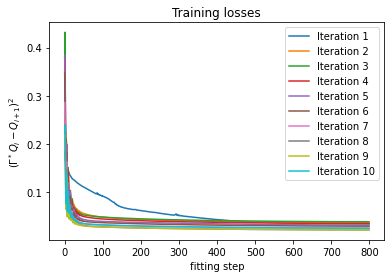

In [9]:
import matplotlib.pyplot as plt 

for bellman_iteration in range(max_bellman_iterations):
    plt.plot(l2_losses[bellman_iteration], label=f"Iteration {bellman_iteration + 1}")

plt.legend()
plt.xlabel("fitting step")
plt.ylabel(r"$(\Gamma^*Q_i - Q_{i +  1})^2$")
plt.title("Training losses")
plt.show()

## Collect weights

In [10]:
from pbo.weights_collection.weights_buffer import WeightsBuffer


weights_buffer = WeightsBuffer()

# Add initial validation weights
weights_buffer.add(validation_initial_weight)

# Add randow weights
q = TableQ(
    gamma=gamma,
    network_key=q_network_key,
    random_weights_range=None,
    random_weights_key=random_weights_key,
    n_states=n_states,
    n_actions=n_actions,
    learning_rate=learning_rate_q
)

while len(weights_buffer) < n_weights:
    weights = q.random_init_weights()
    weights_buffer.add(weights)

weights_buffer.cast_to_jax_array()

NameError: name 'TableQ' is not defined

## Train non linear PBO

In [ ]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import TabularPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo_tabular = TabularPBO(q, max_bellman_iterations, add_infinity, pbo_network_key, learning_rate, n_actions)
importance_iteration = jnp.ones(max_bellman_iterations + 1)
importance_iteration = importance_iteration.at[-1].set(0)

for _ in tqdm(range(training_steps)):
    params_target = pbo_tabular.params

    for _ in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo_tabular.params, pbo_tabular.optimizer_state, _ = pbo_tabular.learn_on_batch(
                    pbo_tabular.params, params_target, pbo_tabular.optimizer_state, batch_weights, batch_samples, importance_iteration
                )

training_losses_tabular = np.zeros(max_bellman_iterations_validation)
validation_losses_tabular = np.zeros(max_bellman_iterations_validation)
absording_probabilities_tabular = np.zeros((max_bellman_iterations_validation, horizon))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo_tabular(pbo_tabular.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses_tabular[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses_tabular[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    absording_probabilities_tabular[bellman_iteration] = env.absorbing_probability(policy_q, horizon)


## Train linear PBO

In [ ]:
from tqdm.notebook import tqdm

from pbo.sample_collection.dataloader import SampleDataLoader
from pbo.weights_collection.dataloader import WeightsDataLoader
from pbo.networks.learnable_pbo import LinearPBO


data_loader_samples = SampleDataLoader(replay_buffer, batch_size_samples, shuffle_key)
data_loader_weights = WeightsDataLoader(weights_buffer, batch_size_weights, shuffle_key)
pbo = LinearPBO(q, max_bellman_iterations, True, pbo_network_key, learning_rate)  # infinity added
importance_iteration = jnp.ones(max_bellman_iterations + 1)


for _ in tqdm(range(training_steps)):
    params_target = pbo.params
    for _ in range(fitting_steps):
        data_loader_weights.shuffle()
        for batch_weights in data_loader_weights:
            data_loader_samples.shuffle()
            for batch_samples in data_loader_samples:
                pbo.params, pbo.optimizer_state, _ = pbo.learn_on_batch(
                    pbo.params, params_target, pbo.optimizer_state, batch_weights, batch_samples, importance_iteration
                )

training_losses = np.zeros(max_bellman_iterations_validation)
validation_losses = np.zeros(max_bellman_iterations_validation)
absording_probabilities = np.zeros((max_bellman_iterations_validation, horizon))

batch_iterated_weights = validation_initial_weight.reshape((1, -1))
for bellman_iteration in range(max_bellman_iterations_validation):
    q_i = q.discretize(batch_iterated_weights, states, actions)[0]
    batch_iterated_weights = pbo(pbo.params, batch_iterated_weights)
    q_i_plus_1 = q.discretize(batch_iterated_weights, states, actions)[0]
    policy_q = q_i_plus_1.argmax(axis=1)

    training_losses[bellman_iteration] = jnp.abs(env.apply_bellman_operator(q_i) - q_i_plus_1).mean()
    validation_losses[bellman_iteration] = jnp.abs(optimal_q - q_i_plus_1).mean()
    absording_probabilities[bellman_iteration] = env.absorbing_probability(policy_q, horizon)

    print(policy_q)

## Visualize errors in Q functions

In [ ]:
import matplotlib.pyplot as plt 

iterations = range(1, max_bellman_iterations_validation + 1)

plt.plot(iterations, validation_losses, label="pbo linear", color="green")
plt.plot(iterations, validation_losses_tabular, label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, validation_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), validation_losses_q, label="FQI", color="red", linewidth=4)
plt.vlines(max_bellman_iterations, 0, np.max(validation_losses_q), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| Q^* - Q_i ||_1$")
_ = plt.legend()

In [ ]:
plt.plot(iterations, training_losses, label="pbo linear", color="green")
plt.plot(iterations, training_losses_tabular, label="pbo max-linear", color="grey")
plt.plot(iterations, training_losses_optimal, label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), training_losses_q, label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, np.maximum(np.max(training_losses_q), np.max(training_losses)), color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$|| \Gamma^*Q_{i-1} - Q_i ||_1$")
_ = plt.legend()

## Understanding the learning process

In [ ]:
empirical_transition_proba = np.zeros((n_states, n_states * n_actions))

for idx_sample in range(len(replay_buffer.states)):
    state = replay_buffer.states[idx_sample, 0]
    action = replay_buffer.actions[idx_sample, 0]
    next_state = replay_buffer.next_states[idx_sample, 0]

    empirical_transition_proba[next_state, state * n_actions + action] += 1 

empirical_transition_proba /= n_repetitions


In [ ]:
np.linalg.norm(empirical_transition_proba - pbo_tabular.params["TabularPBONet/linear"]["w"] / gamma)

## Visualize errors in preformances

In [ ]:
iteration = 5
time = range(1, horizon + 1)


plt.plot(time, absording_probabilities[iteration], label="pbo linear", color="green")
plt.plot(time, absording_probabilities_tabular[iteration], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(time, absording_probabilities_optimal[iteration], label="pbo optimal", color="black")
plt.plot(time, absording_probabilities_q[min([iteration, max_bellman_iterations - 1])], label="FQI", color="red")

plt.xticks(time)
plt.xlabel("time")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)")
_ = plt.legend()

In [ ]:
iteration = 1


plt.plot(iterations, absording_probabilities[:, -1], label="pbo linear", color="green")
plt.plot(iterations, absording_probabilities_tabular[:, -1], label="pbo max-linear", color="grey", linestyle="--")
plt.plot(iterations, absording_probabilities_optimal[:, -1], label="pbo optimal", color="black")
plt.plot(range(1, max_bellman_iterations + 1), absording_probabilities_q[:, -1], label="FQI", color="red")
plt.vlines(max_bellman_iterations, 0, 1, color="black", linestyle="--")

plt.xticks(iterations)
plt.xlabel("iterations")

plt.title(r"$P^{\pi}(s_i =$ absorbing state)" + f" after {horizon} steps")
_ = plt.legend()